In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflowjs as tfjs

In [3]:
from google.colab import files
files.upload()  # upload kaggle.json kamu

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/animal-faces
!unzip animal-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

In [5]:
# Gabungkan dataset train dan val
train_dir = "afhq/train"
val_dir = "afhq/val"
combined_dir = "animal/dataset"
os.makedirs(combined_dir, exist_ok=True)

In [6]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(val_dir):
    category_dir = os.path.join(val_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

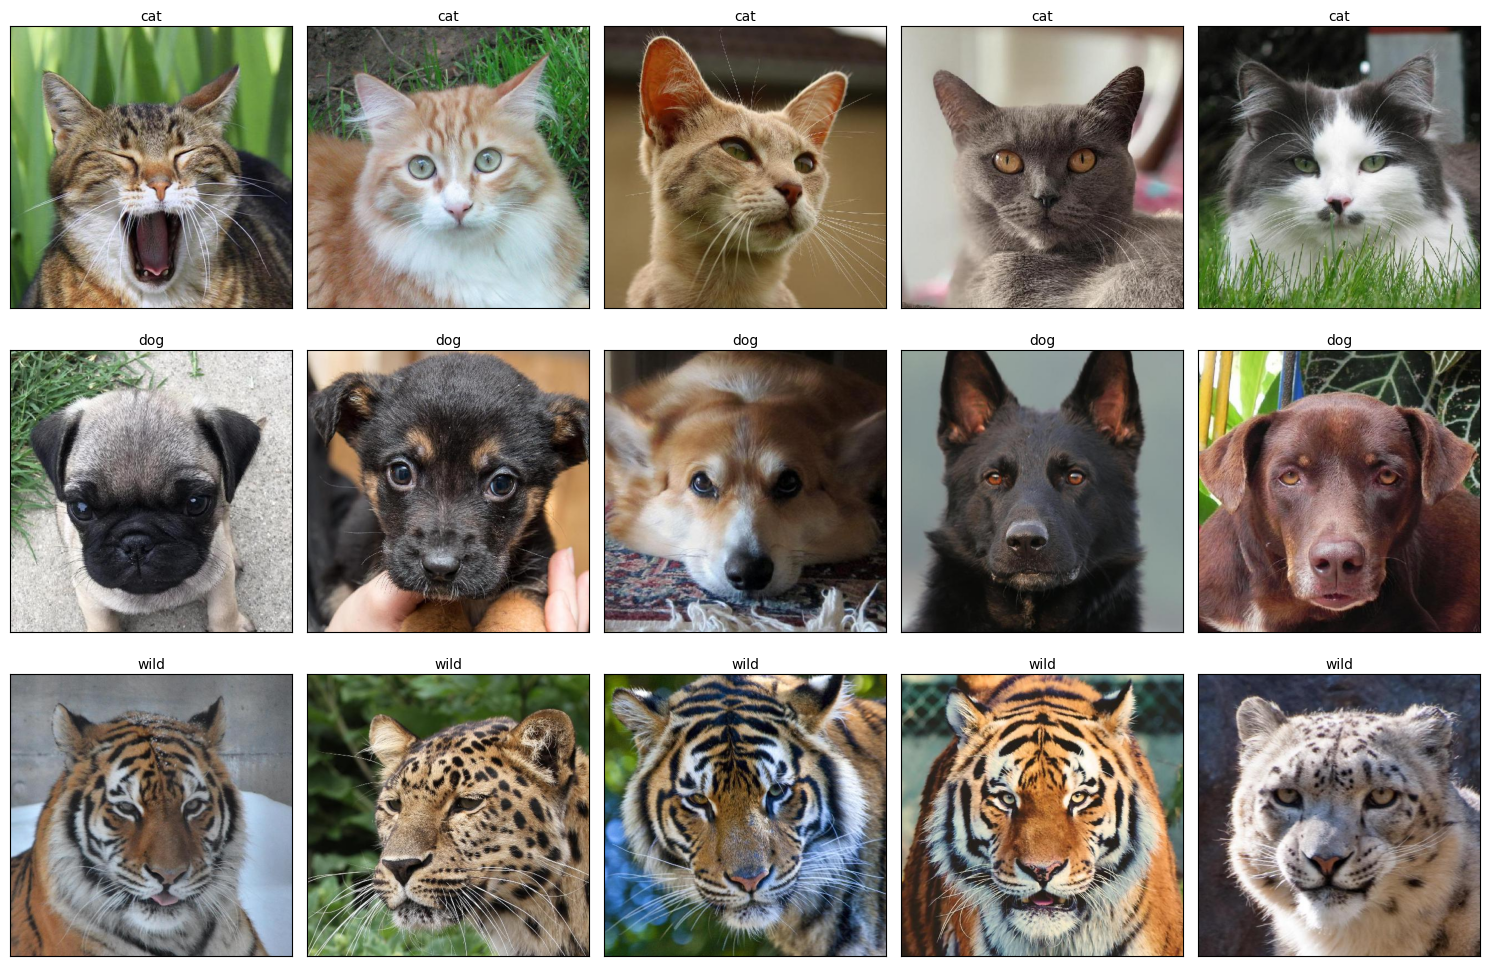

In [7]:
# Visualisasi data
animal_image = {}
path_sub = os.path.join("animal", "dataset")
for category in os.listdir(path_sub):
    category_path = os.path.join(path_sub, category)
    if os.path.isdir(category_path):
        animal_image[category] = os.listdir(category_path)

fig, axs = plt.subplots(len(animal_image.keys()), 5, figsize=(15, 10))
for i, class_name in enumerate(animal_image.keys()):
    images = np.random.choice(animal_image[class_name], 5, replace=False)
    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = plt.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        axs[i, j].xaxis.set_label_position('top')
fig.tight_layout()
plt.show()


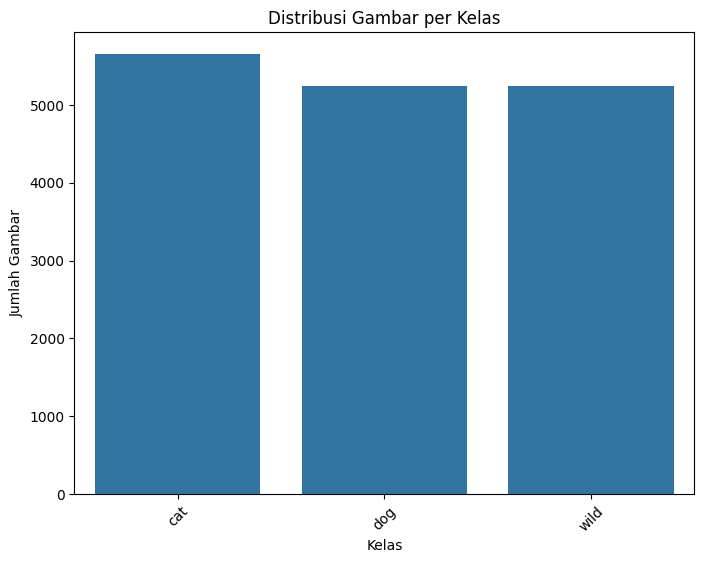

In [8]:
# Distribusi kelas
animal_path = "animal/dataset"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(animal_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

plt.figure(figsize=(8, 6))
sns.countplot(x=distribution_train["labels"])
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(os.listdir(animal_path))

In [10]:
df = distribution_train[["path", "labels"]]
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["labels"], random_state=123)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["labels"], random_state=123)

In [11]:
# ImageDataGenerator untuk augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="path",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11291 validated image filenames belonging to 3 classes.
Found 2419 validated image filenames belonging to 3 classes.
Found 2420 validated image filenames belonging to 3 classes.


In [12]:
# 2. Bangun Model Sequential dengan Conv2D dan MaxPooling2D
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# 3. Latih Model dengan Callback
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
]

In [15]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 202s 540ms/step - accuracy: 0.5015 - loss: 10.4648 - val_accuracy: 0.4101 - val_loss: 1.9198 - learning_rate: 0.0010
Epoch 2/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 182s 515ms/step - accuracy: 0.6760 - loss: 0.7574 - val_accuracy: 0.5920 - val_loss: 2.3868 - learning_rate: 0.0010
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 180s 510ms/step - accuracy: 0.7322 - loss: 0.6562 - val_accuracy: 0.7673 - val_loss: 0.5880 - learning_rate: 0.0010
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 179s 507ms/step - accuracy: 0.7704 - loss: 0.5847 - val_accuracy: 0.8867 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 5/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 177s 501ms/step - accuracy: 0.8337 - loss: 0.4482 - val_accuracy: 0.8036 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 6/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 180s 510ms/step - accuracy: 0.8538 - loss: 0.3946 - val_accuracy: 0.8975 - val_loss: 0.2487 - learning_rate: 0.0010
Epoch 7/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 176s 500ms/step - accur

In [16]:
# 4. Evaluasi Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Akurasi Test: {test_accuracy*100:.2f}%")

76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9849 - loss: 0.0440
Akurasi Test: 98.60%


76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step


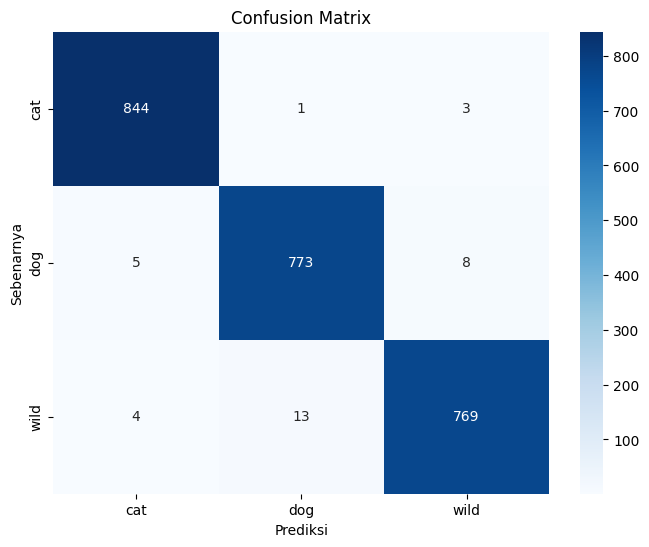

              precision    recall  f1-score   support

         cat       0.99      1.00      0.99       848
         dog       0.98      0.98      0.98       786
        wild       0.99      0.98      0.98       786

    accuracy                           0.99      2420
   macro avg       0.99      0.99      0.99      2420
weighted avg       0.99      0.99      0.99      2420



In [17]:
# Confusion matrix dan classification report
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show()

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

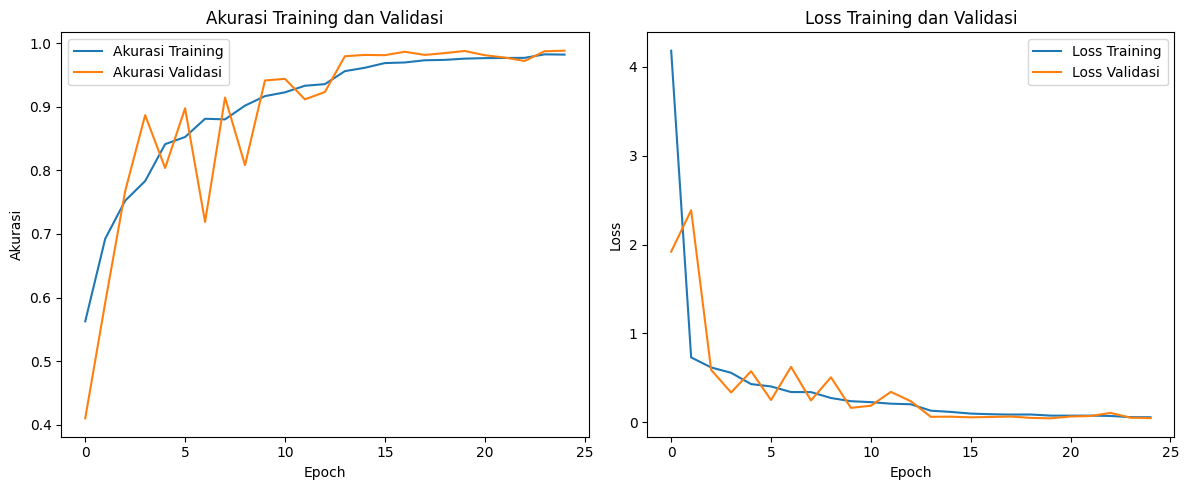

In [18]:
# Plot akurasi dan loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(history.history['accuracy'], label='Akurasi Training')
ax1.plot(history.history['val_accuracy'], label='Akurasi Validasi')
ax1.set_title('Akurasi Training dan Validasi')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Akurasi')
ax1.legend()

ax2.plot(history.history['loss'], label='Loss Training')
ax2.plot(history.history['val_loss'], label='Loss Validasi')
ax2.set_title('Loss Training dan Validasi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [22]:
# Simpan model
model.save("animal_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


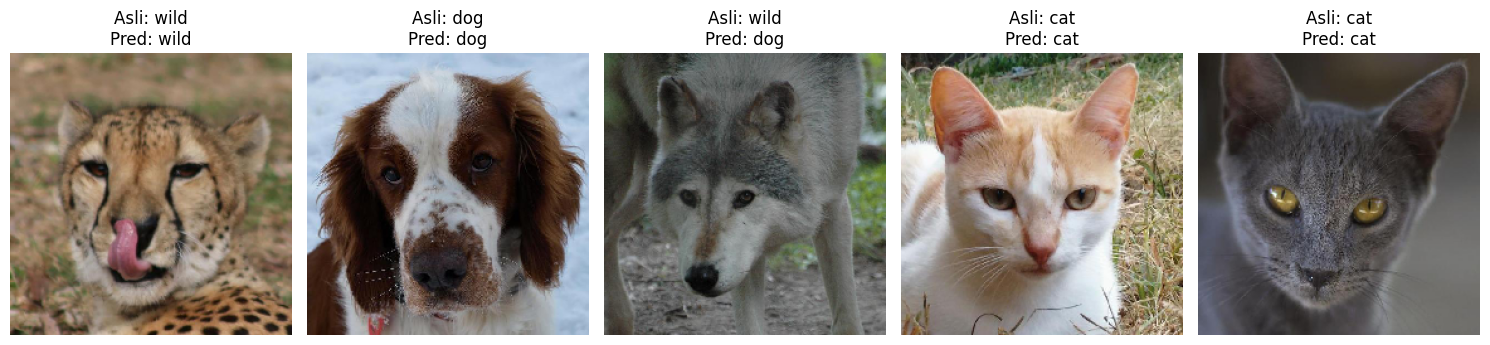

In [23]:
# Load model dari file .keras
from keras.layers import TFSMLayer
from keras import Sequential

model = Sequential([
    TFSMLayer("submissions/saved_model", call_endpoint="serve")
])

# Ambil satu batch dari test_generator
for images, labels in test_generator:
    if len(images) < 5:
        random_indices = list(range(len(images)))
    else:
        random_indices = random.sample(range(len(images)), 5)
    break  # Ambil satu batch saja

# Buat figure untuk menampilkan 5 gambar secara horizontal
plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    test_image = images[idx]
    true_label = list(test_generator.class_indices.keys())[np.argmax(labels[idx])]

    test_image_expanded = np.expand_dims(test_image, axis=0)
    prediction = model.predict(test_image_expanded)
    predicted_class = list(test_generator.class_indices.keys())[np.argmax(prediction[0])]

    # Tampilkan gambar
    plt.subplot(1, 5, i+1)
    plt.imshow(test_image)
    plt.title(f"Asli: {true_label}\nPred: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Buat folder penyimpanan
os.makedirs("submissions/tfjs_model", exist_ok=True)
os.makedirs("submissions/tflite", exist_ok=True)
os.makedirs("submissions/saved_model", exist_ok=True)

# 1. Simpan ke format TensorFlow SavedModel
model.export("submissions/saved_model")

# 2. Simpan ke format TensorFlow.js
tfjs.converters.save_keras_model(model, "submissions/tfjs_model")

# 3. Simpan ke format TFLite
# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open("submissions/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label (kelas)
labels = list(test_generator.class_indices.keys())
with open("submissions/tflite/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

Saved artifact at 'submissions/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133874830261136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825048912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825049296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825048528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825037008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825037200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825047568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825050448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825050832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825049104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1338748

failed to lookup keras version from the file,
    this is likely a weight only file
Saved artifact at '/tmp/tmpt_l0rs0o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  133874830261136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825048912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825049296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825048528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825037008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825037200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825047568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825050448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133874825050832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [24]:
import shutil

# Buat zip dari folder submissions
shutil.make_archive('/content/submissions', 'zip', '/content/submissions')

'/content/submissions.zip'

In [25]:
from IPython.display import FileLink
FileLink(r'/content/submissions.zip')

/content/submissions.zip